In [1]:
import os
from dotenv import load_dotenv
import pandas as pd

from src.datasetgenerator import StratzQuery, DatasetGenerator

In [2]:
load_dotenv()
#querier = StratzQuery(os.getenv('STRATZ_TOKEN'))
#querier.get_match(7590822094)

csv_path = os.getenv('CSV_PATH')

if not os.getenv('STRATZ_TOKEN'):
    raise FileNotFoundError("Not found STRATZ_TOKEN on .env")

generator = DatasetGenerator(os.getenv('STRATZ_TOKEN'), csv_path)

In [3]:
leagues = generator.get_professional_league([16842, 16840])
len(leagues)

2

In [4]:
leagues

{16842: {'id': 16842,
  'name': None,
  'banner': None,
  'tier': 'PROFESSIONAL',
  'region': 'EUROPE',
  'startDateTime': 1717718400,
  'endDateTime': 1719187200,
  'tournamentUrl': 'https://www.dota2.com',
  'lastMatchDate': 1719163998,
  'displayName': 'Road To The International 2024  - Regional Qualifiers Western Europe',
  'description': 'The highly anticipated DOTA 2 tournament, The International 2024, is on the horizon. However, before the main event, teams from the 6 regions without direct invites will have their chance to compete for a spot in the tournament.\nThe Regional Qualifiers for The International 2024 are scheduled to take place from June 9 to June 23.\n',
  'matches': [{'id': 7811671022,
    'didRadiantWin': True,
    'durationSeconds': 2442,
    'startDateTime': 1719161556,
    'firstBloodTime': 93,
    'averageRank': None,
    'players': [{'playerSlot': 0,
      'isRadiant': True,
      'steamAccountId': 331855530,
      'steamAccount': {'rankShift': 2,
       'isA

In [5]:
matches = []
for id, league in leagues.items():
    for match in league['matches']:
        matches.append(match)
len(matches)

80

In [6]:
matches[0]['playbackData']['wardEvents'][0]

{'indexId': 450,
 'time': -63,
 'positionX': 126,
 'positionY': 126,
 'fromPlayer': 4,
 'wardType': 'OBSERVER',
 'action': 'SPAWN',
 'playerDestroyed': None}

In [7]:
def get_deaths_through_ward(match:dict):

    # if match[']
    deaths_through_ward = {
        'time': [],
        'isPlayerRadiant': [],
        'positionX': [],
        'positionY': [],
    }
    for player in match["players"]:
        isPlayerRadiant = player['isRadiant']
        deaths_events = player['playbackData']['deathEvents']
        for d_e in deaths_events:
            if not d_e['isWardWalkThrough']:
                continue
            deaths_through_ward['time'].append(d_e['time'])
            deaths_through_ward['isPlayerRadiant'].append(isPlayerRadiant)
            deaths_through_ward['positionX'].append(d_e['positionX'])
            deaths_through_ward['positionY'].append(d_e['positionY'])
    
    df_deaths = pd.DataFrame.from_dict(deaths_through_ward)
    df_deaths['match'] = match['id']
    return df_deaths

def get_deaths_through_ward_league(league_ids):
    
    league = generator.get_professional_league(league_ids)
    matches = []
    for id, league in leagues.items():
        for match in league['matches']:
            matches.append(match)

    df_deaths = pd.concat([get_deaths_through_ward(match) for match in matches])
    return df_deaths

df_deaths = get_deaths_through_ward_league([16842])
df_deaths

time  isPlayerRadiant  positionX  positionY       match
0   1494             True        182         60  7811671022
1   1418             True        158         70  7811671022
2   1512             True        174         64  7811671022
3    829             True        152         64  7811671022
4   1487             True        194         70  7811671022
..   ...              ...        ...        ...         ...
15  1659             True        106         86  7803686773
16   670            False        114        132  7803686773
17   866            False        122        160  7803686773
18  1637            False         94        104  7803686773
19   662            False        114        122  7803686773

[2218 rows x 5 columns]

In [8]:
from collections import defaultdict

def get_match_wards(match:dict) -> dict:
    player_team_by_slot = {player['playerSlot']: player['isRadiant'] for player in match['players']}
    match_id = match['id']
    didRadiantWin = match['didRadiantWin']
    ward_events = match['playbackData']['wardEvents']
    wards = defaultdict(lambda: {})
    for w_e in ward_events:
        if w_e["action"] == "SPAWN":
            wards[w_e['indexId']] = {
                "id": f"{match_id}_{w_e['indexId']}",
                "match": match_id,
                "spawned_time": w_e["time"],
                "despawned_time": None,
                "positionX": w_e["positionX"],
                "positionY": w_e["positionY"],
                "wardType": w_e["wardType"],
                "isRadiant": player_team_by_slot[w_e["fromPlayer"]],
                "playerDestroyed": w_e["playerDestroyed"],
                "didRadiantWin": didRadiantWin,
            }
            continue
        wards[w_e['indexId']]["despawned_time"] = w_e['time']
    

    # get kills around
    
    return dict(wards)

wards = get_match_wards(matches[0])
wards.keys(), len(wards.keys())

(dict_keys([450, 454, 459, 517, 548, 854, 1877, 1884, 2217, 2224, 2491, 2257, 881, 2227, 2383, 2400, 1656, 2215, 1950, 1683, 1126, 2487, 2146, 2457, 2405, 2047, 2425, 2451, 2088, 1040, 2551, 814, 2226, 2177, 2128, 1918, 2480, 2209, 856, 1848, 920, 1598, 747, 2508, 1720, 2529, 857, 1862, 1554, 2090, 2422, 1672, 541, 921, 1054, 2361, 2397, 1743, 2554, 866, 228, 261, 230, 2132, 2447, 2170, 746, 2152, 848, 2049, 1773, 2038, 2338, 1925, 1858, 1599, 1566, 1810, 2396, 2331, 2079, 2534, 1959, 231, 1926, 2134, 2308, 1768, 2273, 2406, 879, 1631, 452, 461, 775, 1624, 1668, 1713, 1736, 1876, 1775]),
 101)

In [9]:
from collections import defaultdict

def map_death_count(df_wards, df_deaths):
    death_time = df_deaths['time'].item()
    return (df_wards['spawned_time'] < death_time) & (death_time > df_wards['despawned_time'])

def get_df_match_wards(match:dict) -> dict:
    if not match['playbackData']:
        print(f"warning: no playbackData found for match {match['id']}")
        return
    wards = get_match_wards(match)
    df_wards = defaultdict(lambda: [])
    for id, w in wards.items():
        for key, item in w.items():
            df_wards[key].append(item)
    df_wards = pd.DataFrame.from_dict(df_wards)

    none_despawned_mask = df_wards['despawned_time'].isna()
    df_wards.loc[none_despawned_mask, 'despawned_time'] = match['durationSeconds']

    # df_deaths = get_deaths_through_ward(match)
    
    # df_wards['possible_enemies_death'] = 0
    # return map_death_count(df_wards, df_deaths)

    
    # df_wards['possible_enemies_death'] = 0


    df_wards['spawned_time_minute'] = (df_wards['spawned_time'] // 60).astype(int)
    df_wards['despawned_time_minute'] = (df_wards['despawned_time'] // 60).astype(int)
    
    df_wards['radiantTeam'] = match['radiantTeam']['name']
    df_wards['direTeam'] = match['direTeam']['name']


    return df_wards

def get_league_df_wards(league: dict):
    
    ward_matches_df = [get_df_match_wards(match) for match in matches]
    df_wards = pd.concat(ward_matches_df)
    df_wards['league'] = league['id']
    df_wards['region'] = league['region']
    return df_wards

def get_leagues_df_wards(leagues_ids: dict):
    leagues = generator.get_professional_league(leagues_ids)
    df_wards = []
    for league_id, league in leagues.items():
        ward_matches_df = [get_df_match_wards(match) for match in matches]
        ward_matches_df = pd.concat(ward_matches_df)
        ward_matches_df['league'] = league_id
        ward_matches_df['region'] = league['region']
        df_wards.append(ward_matches_df)
    return pd.concat(df_wards)


df_wards = get_leagues_df_wards([16842])


In [10]:
df_wards = df_wards[df_wards['wardType'] == 'OBSERVER'].drop(["wardType", "playerDestroyed"], axis=1)

In [11]:
df_wards.isna().any()

id                       False
match                    False
spawned_time             False
despawned_time           False
positionX                False
positionY                False
isRadiant                False
didRadiantWin            False
spawned_time_minute      False
despawned_time_minute    False
radiantTeam              False
direTeam                 False
league                   False
region                   False
dtype: bool

In [12]:
df_wards[['positionX', 'positionY']].describe()

positionX    positionY
count  2949.000000  2949.000000
mean    125.965412   124.191251
std      28.885027    31.640901
min      58.000000    58.000000
25%     106.000000   100.000000
50%     124.000000   124.000000
75%     146.000000   148.000000
max     194.000000   196.000000

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# bg_img = np.array(Image.open('assets\Game_map_7.33.webp').resize((500,500)))
# # bg_img = mpimg.imread('assets\Game_map_7.33.webp')
# print(type(bg_img), bg_img.shape)
# for name, group in df_wards.groupby('match'):

#     print(f"\n{group['match'].unique()} - {group['radiantTeam'].unique()} x {group['direTeam'].unique()}")
#     fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
#     ax.imshow(bg_img, extent=[55, 200, 55, 200])  # Adjust extent to match your data range
#     ax.scatter(group['positionX'], group['positionY'], label=f'Match {name}', color=group['wardType'].map(lambda x: "yellow" if x == "OBSERVER" else "blue"))

#     # Show plot
#     plt.show()


In [14]:
df_wards.count().max(), df_deaths.count().max()

(np.int64(2949), np.int64(2218))

In [15]:
df_wards[['spawned_time', 'despawned_time']]

spawned_time  despawned_time
0            -63           296.0
1            -62           297.0
2            -53           306.0
3            -17           342.0
12           283           347.0
..           ...             ...
58          1432          1740.0
62          1525          1740.0
66          1590          1740.0
67          1615          1740.0
69          1701          1740.0

[2949 rows x 2 columns]

In [16]:
df_wards = df_wards.reset_index()
df_wards

index               id       match  spawned_time  despawned_time  \
0         0   7811671022_450  7811671022           -63           296.0   
1         1   7811671022_454  7811671022           -62           297.0   
2         2   7811671022_459  7811671022           -53           306.0   
3         3   7811671022_517  7811671022           -17           342.0   
4        12   7811671022_881  7811671022           283           347.0   
...     ...              ...         ...           ...             ...   
2944     58  7803686773_2365  7803686773          1432          1740.0   
2945     62  7803686773_1600  7803686773          1525          1740.0   
2946     66  7803686773_2102  7803686773          1590          1740.0   
2947     67  7803686773_1810  7803686773          1615          1740.0   
2948     69  7803686773_2476  7803686773          1701          1740.0   

      positionX  positionY  isRadiant  didRadiantWin  spawned_time_minute  \
0           126        126       True           True                   -2   
1           154        100       True           True                   -2   
2           120        122      False           True                   -1   
3           138         82      False           True                   -1   
4           122        128      False           True                    4   
...         ...        ...        ...            ...                  ...   
2944        112         82      False          False                   23   
2945         80        110      False          False                   25   
2946        126        116       True          False                   26   
2947         94        118      False          False                   26   
2948         76         98      False          False                   28   

      despawned_time_minute     radiantTeam      direTeam  league  region  
0                         4  Tundra Esports     PSG.Quest   16842  EUROPE  
1                         4  Tundra Esports     PSG.Quest   16842  EUROPE  
2                         5  Tundra Esports     PSG.Quest   16842  EUROPE  
3                         5  Tundra Esports     PSG.Quest   16842  EUROPE  
4                         5  Tundra Esports     PSG.Quest   16842  EUROPE  
...                     ...             ...           ...     ...     ...  
2944                     29   Manta Esports  Aurora.1xBet   16842  EUROPE  
2945                     29   Manta Esports  Aurora.1xBet   16842  EUROPE  
2946                     29   Manta Esports  Aurora.1xBet   16842  EUROPE  
2947                     29   Manta Esports  Aurora.1xBet   16842  EUROPE  
2948                     29   Manta Esports  Aurora.1xBet   16842  EUROPE  

[2949 rows x 15 columns]

In [17]:
def create_time_rows(row):
    return [{'time': t, **row} for t in range(row['spawned_time_minute'], row['despawned_time_minute']) if row['id']]
# Apply the function and expand the DataFrame
df_expanded = df_wards.apply(create_time_rows, axis=1).explode().reset_index(drop=True)

# Convert the expanded rows from dictionaries back to a DataFrame
df_expanded = pd.DataFrame([row for row in df_expanded.tolist() if isinstance(row, dict)])

# Drop the original columns (optional)
df_expanded.drop(['spawned_time', 'despawned_time','spawned_time_minute', 'despawned_time_minute'], axis=1, inplace=True)

# Print the expanded DataFrame
df_expanded

time  index               id       match  positionX  positionY  \
0        -2      0   7811671022_450  7811671022        126        126   
1        -1      0   7811671022_450  7811671022        126        126   
2         0      0   7811671022_450  7811671022        126        126   
3         1      0   7811671022_450  7811671022        126        126   
4         2      0   7811671022_450  7811671022        126        126   
...     ...    ...              ...         ...        ...        ...   
12866    28     66  7803686773_2102  7803686773        126        116   
12867    26     67  7803686773_1810  7803686773         94        118   
12868    27     67  7803686773_1810  7803686773         94        118   
12869    28     67  7803686773_1810  7803686773         94        118   
12870    28     69  7803686773_2476  7803686773         76         98   

       isRadiant  didRadiantWin     radiantTeam      direTeam  league  region  
0           True           True  Tundra Esports     PSG.Quest   16842  EUROPE  
1           True           True  Tundra Esports     PSG.Quest   16842  EUROPE  
2           True           True  Tundra Esports     PSG.Quest   16842  EUROPE  
3           True           True  Tundra Esports     PSG.Quest   16842  EUROPE  
4           True           True  Tundra Esports     PSG.Quest   16842  EUROPE  
...          ...            ...             ...           ...     ...     ...  
12866       True          False   Manta Esports  Aurora.1xBet   16842  EUROPE  
12867      False          False   Manta Esports  Aurora.1xBet   16842  EUROPE  
12868      False          False   Manta Esports  Aurora.1xBet   16842  EUROPE  
12869      False          False   Manta Esports  Aurora.1xBet   16842  EUROPE  
12870      False          False   Manta Esports  Aurora.1xBet   16842  EUROPE  

[12871 rows x 12 columns]

In [18]:
df_expanded.drop(['index'],axis=1, inplace=True)
df_expanded.dtypes

time              int64
id               object
match             int64
positionX         int64
positionY         int64
isRadiant          bool
didRadiantWin      bool
radiantTeam      object
direTeam         object
league            int64
region           object
dtype: object

In [19]:
train_data = df_expanded.copy()
train_data["win"] = train_data['isRadiant'] == train_data['didRadiantWin']
train_data.drop(['id', 'match', 'didRadiantWin', 'radiantTeam', 'direTeam', 'league', 'region'], axis=1, inplace=True)
train_data['isRadiant'] = train_data['isRadiant'].astype(int)
train_data['win'] = train_data['win'].astype(int)
train_data

time  positionX  positionY  isRadiant  win
0        -2        126        126          1    1
1        -1        126        126          1    1
2         0        126        126          1    1
3         1        126        126          1    1
4         2        126        126          1    1
...     ...        ...        ...        ...  ...
12866    28        126        116          1    0
12867    26         94        118          0    1
12868    27         94        118          0    1
12869    28         94        118          0    1
12870    28         76         98          0    1

[12871 rows x 5 columns]

In [20]:
def create_time_rows(row):
    return [{'time': t, **row} for t in range(row['spawned_time_minute'], row['despawned_time_minute']) if row['id']]

In [21]:
def get_dataset():
    df_wards = get_leagues_df_wards([16842, 16840])
    
    df_wards = df_wards[df_wards['wardType'] == 'OBSERVER'].drop(["wardType", "playerDestroyed"], axis=1)
    
    # Apply the function and expand the DataFrame
    df_expanded = df_wards.apply(create_time_rows, axis=1).explode().reset_index(drop=True)

    # Convert the expanded rows from dictionaries back to a DataFrame
    df_expanded = pd.DataFrame([row for row in df_expanded.tolist() if isinstance(row, dict)])

    # Drop the original columns (optional)
    df_expanded.drop(['spawned_time', 'despawned_time','spawned_time_minute', 'despawned_time_minute'], axis=1, inplace=True)

    # Print the expanded DataFrame

    
    train_data = df_expanded.copy()
    train_data["win"] = train_data['isRadiant'] == train_data['didRadiantWin']
    train_data.drop(['id', 'match', 'didRadiantWin', 'radiantTeam', 'direTeam', 'league', 'region'], axis=1, inplace=True)
    train_data['isRadiant'] = train_data['isRadiant'].astype(int)
    train_data['win'] = train_data['win'].astype(int)
    return train_data

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

train_data = get_dataset()

X = np.array(train_data.drop(["win"], axis=1))
y = np.array(train_data['win'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
X_train.shape, X_test.shape

((18019, 4), (7723, 4))

In [23]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)


DecisionTreeClassifier()

In [24]:
classifier.predict_proba(X)

array([[0.75, 0.25],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       ...,
       [0.5 , 0.5 ],
       [0.  , 1.  ],
       [0.  , 1.  ]])

In [25]:
sum(classifier.predict(X_test) == y_test) / y_test.shape

array([0.8381458])

In [26]:
new_df = []
for (match, time, isRadiant), grouped_match in df_expanded.groupby(['match', 'time', 'isRadiant']):
    new_df_grouped = grouped_match.iloc[0:1].copy()
    new_df_grouped['positionX_0'] = new_df_grouped['positionX']
    new_df_grouped['positionY_0'] = new_df_grouped['positionY']
    for i, (_, row) in enumerate(grouped_match.iloc[1:].iterrows()):
        new_df_grouped[f"positionX_{i+1}"] = row['positionX']
        new_df_grouped[f"positionY_{i+1}"] = row['positionY']
    new_df.append(new_df_grouped)

df_merged = pd.concat(new_df)
df_merged = df_merged.reset_index().drop(['index', 'positionX', 'positionY'], axis=1)
df_merged

time               id       match  isRadiant  didRadiantWin  \
0       -1   7803686773_460  7803686773      False          False   
1       -1   7803686773_468  7803686773       True          False   
2        0   7803686773_460  7803686773      False          False   
3        0   7803686773_468  7803686773       True          False   
4        1   7803686773_460  7803686773      False          False   
...    ...              ...         ...        ...            ...   
6329    37  7811671022_2079  7811671022       True           True   
6330    38  7811671022_1631  7811671022      False           True   
6331    38  7811671022_2079  7811671022       True           True   
6332    39  7811671022_1631  7811671022      False           True   
6333    39  7811671022_1768  7811671022       True           True   

         radiantTeam      direTeam  league  region  positionX_0  ...  \
0      Manta Esports  Aurora.1xBet   16842  EUROPE          126  ...   
1      Manta Esports  Aurora.1xBet   16842  EUROPE          146  ...   
2      Manta Esports  Aurora.1xBet   16842  EUROPE          126  ...   
3      Manta Esports  Aurora.1xBet   16842  EUROPE          146  ...   
4      Manta Esports  Aurora.1xBet   16842  EUROPE          126  ...   
...              ...           ...     ...     ...          ...  ...   
6329  Tundra Esports     PSG.Quest   16842  EUROPE          174  ...   
6330  Tundra Esports     PSG.Quest   16842  EUROPE          150  ...   
6331  Tundra Esports     PSG.Quest   16842  EUROPE          174  ...   
6332  Tundra Esports     PSG.Quest   16842  EUROPE          150  ...   
6333  Tundra Esports     PSG.Quest   16842  EUROPE          124  ...   

      positionX_1  positionY_1  positionX_2  positionY_2  positionX_3  \
0           140.0         94.0          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2           140.0         94.0          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4           140.0         94.0          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
6329        124.0        186.0        148.0         72.0        188.0   
6330          NaN          NaN          NaN          NaN          NaN   
6331        124.0        186.0        148.0         72.0        188.0   
6332        118.0        138.0          NaN          NaN          NaN   
6333        148.0         72.0        188.0        114.0        164.0   

      positionY_3  positionX_4  positionY_4  positionX_5  positionY_5  
0             NaN          NaN          NaN          NaN          NaN  
1             NaN          NaN          NaN          NaN          NaN  
2             NaN          NaN          NaN          NaN          NaN  
3             NaN          NaN          NaN          NaN          NaN  
4             NaN          NaN          NaN          NaN          NaN  
...           ...          ...          ...          ...          ...  
6329        114.0        164.0        132.0          NaN          NaN  
6330          NaN          NaN          NaN          NaN          NaN  
6331        114.0        164.0        132.0        174.0        146.0  
6332          NaN          NaN          NaN          NaN          NaN  
6333        132.0        136.0        154.0          NaN          NaN  

[6334 rows x 21 columns]

In [27]:
df_merged.isna().any()

time             False
id               False
match            False
isRadiant        False
didRadiantWin    False
radiantTeam      False
direTeam         False
league           False
region           False
positionX_0      False
positionY_0      False
positionX_1       True
positionY_1       True
positionX_2       True
positionY_2       True
positionX_3       True
positionY_3       True
positionX_4       True
positionY_4       True
positionX_5       True
positionY_5       True
dtype: bool

In [28]:
df_expanded.isna().any()

time             False
id               False
match            False
positionX        False
positionY        False
isRadiant        False
didRadiantWin    False
radiantTeam      False
direTeam         False
league           False
region           False
dtype: bool

In [29]:
df_expanded[['positionX', 'positionY']].describe()

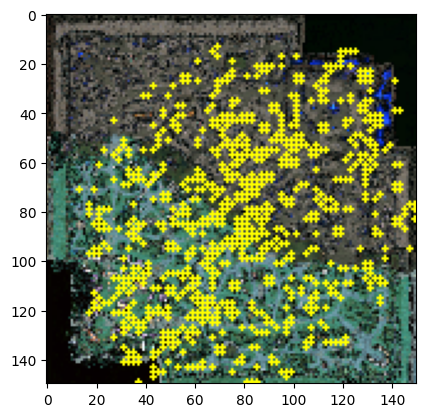

In [31]:
import cv2
map = cv2.imread("assets"+os.sep+"Game_map_7.33.webp")
map = cv2.resize(map, (150,150))
def plot_ward(wards):
    plotted_map = map.copy()
    positions_x = list(wards['positionX'])
    positions_y = list(wards['positionY'])
    radius = 1
    color = (255, 255, 0)
    thickness = -1
    for center in zip(positions_x, positions_y):
        cv2.circle(plotted_map, center, radius, color, thickness)
    return plotted_map

plotted_map = plot_ward(df_expanded)
plt.imshow(plotted_map)